In [1]:
# Python Modules
import numpy as np
import pandas as pd
import os

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Modeling
from sklearn.linear_model import LinearRegression
import pmdarima as pm
import statsmodels.api as sm

%matplotlib inline
%load_ext nb_black

plt.rcParams["figure.figsize"] = (14, 7)

<IPython.core.display.Javascript object>

-------------

## Read in Data

In [2]:
def read_zori(filename):
    """
    Read ZORI Data

    Data from: https://www.zillow.com/research/methodology-zori-repeat-rent-27092/
    """
    zori_colnames = (pd.read_csv(filename, nrows=1)).columns
    keep_cols = ["RegionName", "SizeRank", "State", "City", "Metro", "CountyName"]
    keep_cols.extend(list(zori_colnames[9:]))
    date_cols = zori_colnames[9:]
    dtype_map = {}
    for kc in ["RegionName", "SizeRank", "State", "City", "Metro", "CountyName"]:
        dtype_map[kc] = str
    for dc in date_cols:
        dtype_map[dc] = np.float64

    df = pd.read_csv(filename, usecols=keep_cols, dtype=dtype_map)
    df.rename(columns={"RegionName": "zipcode"}, inplace=True)

    df = df.melt(
        id_vars=["zipcode", "SizeRank", "State", "City", "Metro", "CountyName"],
        var_name="month",
        value_name="zori",
    )

    df.month = pd.to_datetime(df.month)
    df.sort_values(["zipcode", "month"], inplace=True)
    return df

<IPython.core.display.Javascript object>

In [3]:
zori = read_zori("../data/zillow/Zip_zori_sm_month.csv")
zori.head()

,zipcode,SizeRank,State,City,Metro,CountyName,month,zori
3083,01002,3602,MA,Amherst,"Springfield, MA",Hampshire County,2015-03-31,NaN
8983,01002,3602,MA,Amherst,"Springfield, MA",Hampshire County,2015-04-30,NaN
14883,01002,3602,MA,Amherst,"Springfield, MA",Hampshire County,2015-05-31,NaN
20783,01002,3602,MA,Amherst,"Springfield, MA",Hampshire County,2015-06-30,NaN
26683,01002,3602,MA,Amherst,"Springfield, MA",Hampshire County,2015-07-31,NaN


<IPython.core.display.Javascript object>

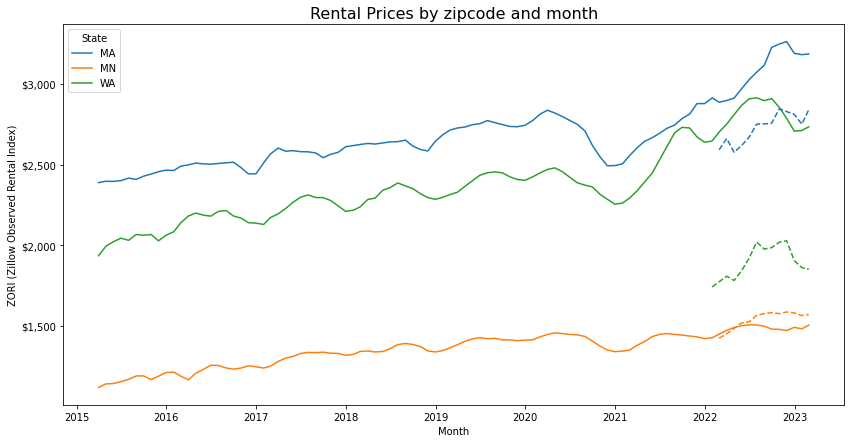

<IPython.core.display.Javascript object>

In [4]:
fig, ax = plt.subplots(1, 1)
["02215", "02122", "98004", "98020", "55408", "55113"]
g = sns.lineplot(
    data=zori[zori.zipcode.isin(["02215", "98004", "55408"])],
    x="month",
    y="zori",
    # marker="o",
    hue="State",
    linestyle="solid",
    ax=ax,
)
g2 = sns.lineplot(
    data=zori[zori.zipcode.isin(["02122", "98020", "55113"])],
    x="month",
    y="zori",
    # marker="o",
    hue="State",
    linestyle="dashed",
    ax=ax,
    legend=False,
)

fmt = "${x:,.0f}"
tick = mtick.StrMethodFormatter(fmt)
_ = ax.yaxis.set_major_formatter(tick)
_ = g.set_ylabel("ZORI (Zillow Observed Rental Index)")
_ = g.set_xlabel("Month")
_ = g.set_title("Rental Prices by zipcode and month", fontsize=16)

The graph above shows the ZORI for six different time series.

I'm plotting full time series since 2015 for three different metro areas (Boston, Minneapolis, Bellevue/Seattle).
For each metro area, the full time series represents a zip code that we could think of as the city center. There are also secondary time series that starts around 2022. These time series are taken from suburbs of the main city center.  The idea here is that we don't have a long enough history for the short time series to fit TS models.

Suppose your company has operations in Boston, Bellevue, and Minneapolis proper but now wants to expand into the suburbs.  We need to come up with a reasonable way to forecast for these three areas.

-------------------

In [5]:
def get_complete(df):
    df["missing_ind"] = df.zori.isna()
    missing_df = (
        df.groupby("zipcode").agg(count_missing=("missing_ind", "sum")).reset_index()
    )
    missing_df = missing_df[missing_df.count_missing == 0]
    print(missing_df)
    del df["missing_ind"]
    del missing_df["count_missing"]
    df = df.merge(missing_df, on=["zipcode"], how="inner")

    return df


zori_complete = get_complete(zori)

     zipcode  count_missing
65     02111              0
66     02113              0
67     02114              0
68     02115              0
69     02116              0
...      ...            ...
5816   98374              0
5817   98375              0
5827   98405              0
5848   98516              0
5856   98661              0

[916 rows x 2 columns]


<IPython.core.display.Javascript object>

In [6]:
def lr_data_prep(df):
    df["time_periods"] = np.round(
        (df.month - df.month.min()) / np.timedelta64(1, "M")
    ).astype("int")
    return df


def lr_slopes(df):
    df["time_periods"] = np.round(
        (df.month - df.month.min()) / np.timedelta64(1, "M")
    ).astype("int")

    tuples = []
    for zc in df.zipcode.unique():
        lr_df = df[df.zipcode == zc]

        reg = LinearRegression().fit(X=lr_df[["time_periods"]], y=lr_df.zori)
        intercept = reg.intercept_
        slope = reg.coef_[0]
        tuples.append((zc, intercept, slope))

    results = pd.DataFrame(tuples, columns=["zipcode", "intercept", "slope"])

    return results


reg_results = lr_slopes(zori_complete)

<IPython.core.display.Javascript object>

In [7]:
zori_complete = zori_complete.merge(reg_results, on="zipcode", how="left")
zori_complete["zori_pred_linreg"] = (
    zori_complete["intercept"] + zori_complete["slope"] * zori_complete["time_periods"]
)

<IPython.core.display.Javascript object>

<AxesSubplot: xlabel='month', ylabel='zori'>

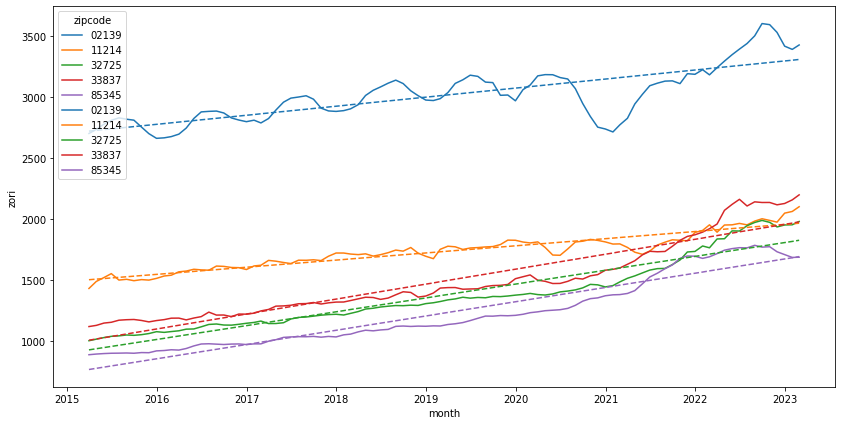

<IPython.core.display.Javascript object>

In [8]:
zcs = np.random.choice(zori_complete.zipcode.unique(), 5, replace=False)


sns.lineplot(
    data=zori_complete[zori_complete.zipcode.isin(zcs)],
    x="month",
    y="zori",
    hue="zipcode",
)
sns.lineplot(
    data=zori_complete[zori_complete.zipcode.isin(zcs)],
    x="month",
    y="zori_pred_linreg",
    hue="zipcode",
    linestyle="dashed",
)

Text(0.5, 1.0, 'Histogram of Rent Growth Rate by Zipcodes')

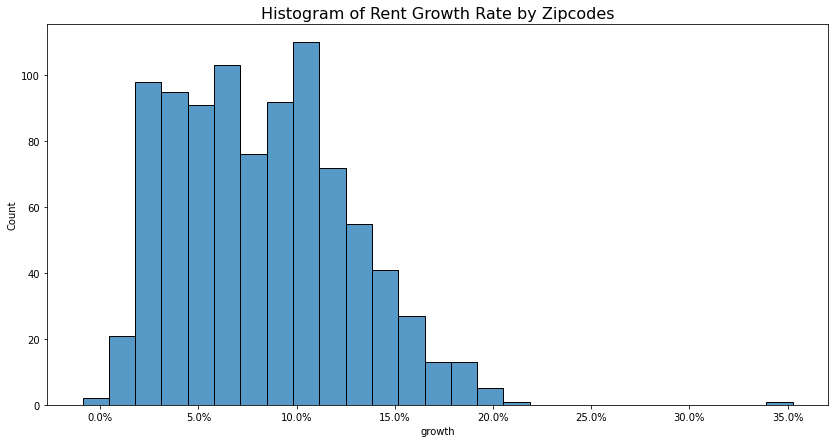

<IPython.core.display.Javascript object>

In [21]:
reg_results["growth"] = 12 * reg_results["slope"] / reg_results["intercept"]
# fig, ax = plt.subplots(1,1)
g = sns.histplot(data=reg_results, x="growth")
g.xaxis.set_major_formatter(mtick.PercentFormatter(1))
g.set_title("Histogram of Rent Growth Rate by Zipcodes", fontsize=16)

-----------------

## Variability

Get the Sigma2 estimate from an arima model for each zip code

In [22]:
zori_complete

,zipcode,SizeRank,State,City,Metro,CountyName,month,zori,time_periods,intercept,slope,zori_pred_linreg
0,02111,10852,MA,Boston,"Boston-Cambridge-Newton, MA-NH",Suffolk County,2015-03-31,3108.566248,0,3052.768364,5.633136,3052.768364
1,02111,10852,MA,Boston,"Boston-Cambridge-Newton, MA-NH",Suffolk County,2015-04-30,3184.785989,1,3052.768364,5.633136,3058.401500
2,02111,10852,MA,Boston,"Boston-Cambridge-Newton, MA-NH",Suffolk County,2015-05-31,3219.696053,2,3052.768364,5.633136,3064.034635
3,02111,10852,MA,Boston,"Boston-Cambridge-Newton, MA-NH",Suffolk County,2015-06-30,3186.497015,3,3052.768364,5.633136,3069.667771
4,02111,10852,MA,Boston,"Boston-Cambridge-Newton, MA-NH",Suffolk County,2015-07-31,3190.627191,4,3052.768364,5.633136,3075.300906
...,...,...,...,...,...,...,...,...,...,...,...,...
87931,98661,1046,WA,Vancouver,"Portland-Vancouver-Hillsboro, OR-WA",Clark County,2022-10-31,1638.592967,91,905.343455,7.017100,1543.899576
87932,98661,1046,WA,Vancouver,"Portland-Vancouver-Hillsboro, OR-WA",Clark County,2022-11-30,1626.145469,92,905.343455,7.017100,1550.916676
87933,98661,1046,WA,Vancouver,"Portland-Vancouver-Hillsboro, OR-WA",Clark County,2022-12-31,1636.107466,93,905.343455,7.017100,1557.933776
87934,98661,1046,WA,Vancouver,"Portland-Vancouver-Hillsboro, OR-WA",Clark County,2023-01-31,1652.701621,94,905.343455,7.017100,1564.950877


<IPython.core.display.Javascript object>

In [35]:
def arima_stds(df):
    df["time_periods"] = np.round(
        (df.month - df.month.min()) / np.timedelta64(1, "M")
    ).astype("int")

    tuples = []
    for zc in df.zipcode.unique():
        print(zc)
        zcd = df[df.zipcode == zc].copy()

        zcd["zori_diff"] = zcd.zori.diff()
        zcd["zori_log"] = np.log(zcd.zori)
        zcd["zori_lr"] = zcd.zori_log.diff()

        zcd.set_index("month")

        # Fit an ARIMA model using the pmdarima auto_arima function
        model = pm.auto_arima(
            zcd.iloc[1:].zori_lr,
            seasonal=False,
            stationary=True,
            max_p=4,
            max_q=4,
            error_action="ignore",
        )
        # print(model.params())

        # Print the optimal values of p and q determined by the auto_arima function
        # print("Optimal values of p and q:", model.order)
        tuples.append((zcd.zipcode, model.order, model.params()["sigma2"]))

    results = pd.DataFrame(tuples, columns=["zipcode", "order", "sigma2"])

    return results


arima_results = arima_stds(zori_complete)

02111
02113
02114
02115
02116
02118
02125
02127
02128
02129
02130
02134
02135
02138
02139
02140
02141
02143
02144
02145
02148
02155
02169
02215
02445
02446
02453
02472
02840
02906
06460
06511
06902
07002
07024
07030
07047
07087
07093
07302
07305
07306
07307
08540
10001
10002
10003
10005
10006
10010
10011
10012
10013
10014
10017
10018
10019
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10035
10036
10038
10040
10065
10075
10128
10458
10461
10462
10463
10467
11101
11102
11103
11105
11106
11109
11201
11205
11206
11207
11209
11211
11213
11214
11215
11216
11217
11218
11220
11221
11222
11225
11226
11228
11229
11230
11231
11233
11235
11237
11238
11249
11354
11355
11374
11375
11385
11561
15203
19103
19104
19106
19107
19121
19123
19125
19127
19128
19130
19139
19145
19146
19147
19148
20001
20002
20003
20005
20009
20147
20170
20171
20190
20814
20850
20852
20874
20878
20902
20906
21045
21113
21217
21218
21224
21230
21231
21701
21703
22030
22033
22102
22191
22192
2219

<IPython.core.display.Javascript object>

In [47]:
arima_results.to_csv("../arima_results.csv", index=False)

<IPython.core.display.Javascript object>

In [48]:
arima_results

,zipcode,order,sigma2
0,02111,"(4, 0, 3)",0.000121
1,02113,"(2, 0, 2)",0.000207
2,02114,"(1, 0, 2)",0.000084
3,02115,"(1, 0, 2)",0.000058
4,02116,"(1, 0, 3)",0.000076
...,...,...,...
911,98374,"(3, 0, 2)",0.000052
912,98375,"(2, 0, 2)",0.000055
913,98405,"(3, 0, 3)",0.000101
914,98516,"(0, 0, 4)",0.000049


<IPython.core.display.Javascript object>

--------------

In [42]:
combined_results = pd.merge(reg_results, arima_results, on=["zipcode"], how="outer")
combined_results

,zipcode,intercept,slope,growth,order,sigma2
0,02111,3052.768364,5.633136,0.022143,"(4, 0, 3)",0.000121
1,02113,2068.644654,4.715239,0.027353,"(2, 0, 2)",0.000207
2,02114,2569.939636,4.489854,0.020965,"(1, 0, 2)",0.000084
3,02115,2531.926365,5.244597,0.024857,"(1, 0, 2)",0.000058
4,02116,2538.644342,4.708643,0.022257,"(1, 0, 3)",0.000076
...,...,...,...,...,...,...
911,98374,1327.293542,10.940977,0.098917,"(3, 0, 2)",0.000052
912,98375,1344.596802,13.162511,0.117470,"(2, 0, 2)",0.000055
913,98405,810.850455,8.641404,0.127887,"(3, 0, 3)",0.000101
914,98516,1266.024589,10.886795,0.103190,"(0, 0, 4)",0.000049


<IPython.core.display.Javascript object>

    zipcode   intercept     slope    growth      order    sigma2
782   89509  465.311232  13.67304  0.352617  (0, 0, 3)  0.001269


<AxesSubplot: xlabel='month', ylabel='zori'>

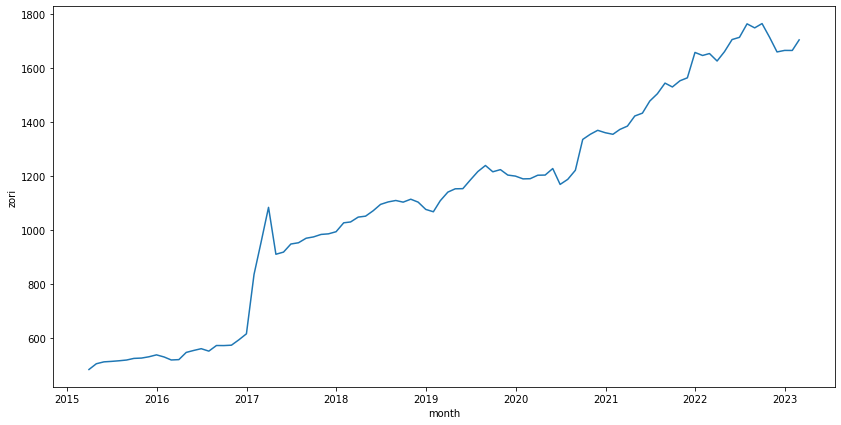

<IPython.core.display.Javascript object>

In [45]:
print(combined_results[combined_results.growth > 0.30])
sns.lineplot(data=zori_complete[zori_complete.zipcode == "89509"], x="month", y="zori")

<AxesSubplot: xlabel='growth', ylabel='sigma2'>

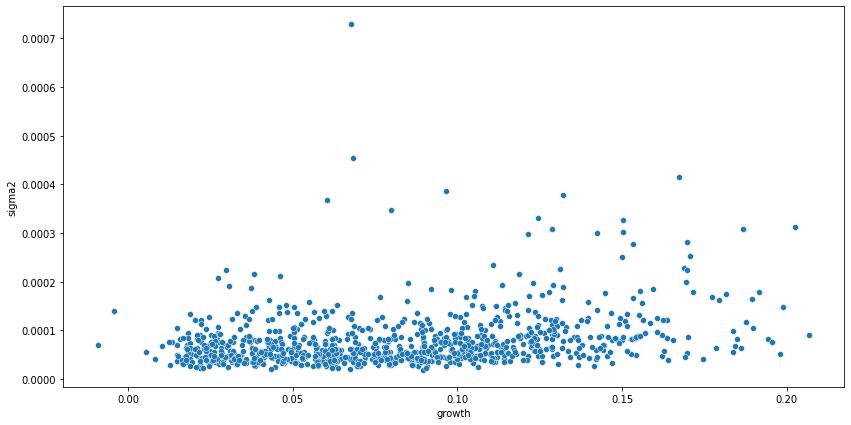

<IPython.core.display.Javascript object>

In [46]:
sns.scatterplot(
    data=combined_results[combined_results.growth <= 0.30], x="growth", y="sigma2"
)

---------------

In [50]:
wa_data = zori[zori.zipcode == "98004"]
wa_data.set_index("month", inplace=True)
wa_data = wa_data.asfreq("M")
wa_data["time_periods"] = np.round(
    (wa_data.index - wa_data.index.min()) / np.timedelta64(1, "M")
).astype("int")
wa_data.head()

,zipcode,SizeRank,State,City,Metro,CountyName,zori,time_periods
month,,,,,,,,
2015-03-31,98004,2280,WA,Bellevue,"Seattle-Tacoma-Bellevue, WA",King County,1936.065570,0
2015-04-30,98004,2280,WA,Bellevue,"Seattle-Tacoma-Bellevue, WA",King County,1994.690249,1
2015-05-31,98004,2280,WA,Bellevue,"Seattle-Tacoma-Bellevue, WA",King County,2023.182831,2
2015-06-30,98004,2280,WA,Bellevue,"Seattle-Tacoma-Bellevue, WA",King County,2044.498418,3
2015-07-31,98004,2280,WA,Bellevue,"Seattle-Tacoma-Bellevue, WA",King County,2031.146921,4


<IPython.core.display.Javascript object>

In [51]:
reg = LinearRegression().fit(X=wa_data[["time_periods"]], y=wa_data.zori)
bellevue_preds = reg.predict(wa_data[["time_periods"]])

<IPython.core.display.Javascript object>

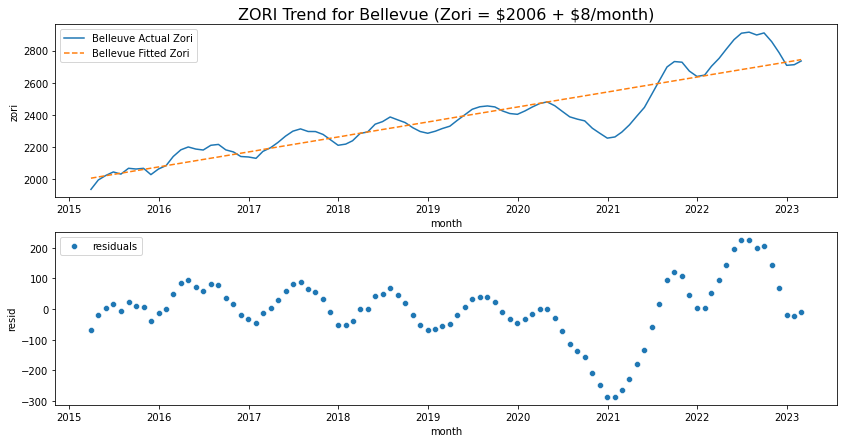

<IPython.core.display.Javascript object>

In [52]:
temp = wa_data.copy()
reg = LinearRegression().fit(X=temp[["time_periods"]], y=temp.zori)
temp["zori_fit"] = reg.predict(temp[["time_periods"]])
temp.reset_index(inplace=True)
temp["resid"] = temp["zori"] - temp["zori_fit"]
fig, (ax1, ax2) = plt.subplots(2, 1)
g = sns.lineplot(
    data=temp,
    x="month",
    y="zori",
    linestyle="solid",
    ax=ax1,
    label="Belleuve Actual Zori",
)
_ = sns.lineplot(
    data=temp,
    x="month",
    y="zori_fit",
    linestyle="dashed",
    ax=ax1,
    label="Bellevue Fitted Zori",
)
_ = sns.scatterplot(data=temp, x="month", y="resid", ax=ax2, label="residuals")
bv_int = round(reg.intercept_)
bv_slope = round(reg.coef_[0])
_ = g.set_title(f"ZORI Trend for Bellevue (Zori = \${bv_int} + \${bv_slope}/month)", fontsize=16)


In [ ]:
zori["is_zori_missing"] = zori.zori.isna()
zori_missing = zori.groupby("zipcode")["is_zori_missing"].sum().reset_index()
plt.hist(zori_missing.is_zori_missing)

In [ ]:
zori_missing[zori_missing.is_zori_missing == 0].zipcode

In [ ]:
zori_complete = zori.merge(
    zori_missing[zori_missing.is_zori_missing == 0], on=["zipcode"], how="inner"
)
zori_

In [ ]:
zori_complete.head()

In [ ]:
zori.shape

In [ ]:
len(zori.zipcode.unique())

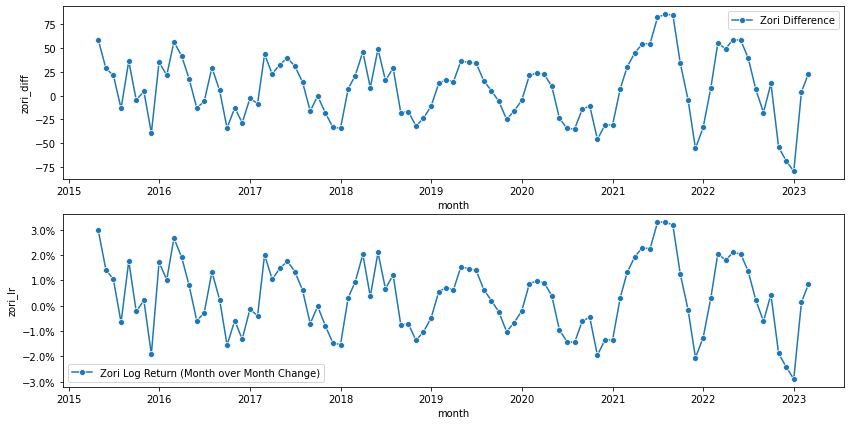

<IPython.core.display.Javascript object>

In [53]:
wa_data["zori_diff"] = wa_data.zori.diff()
wa_data["zori_log"] = np.log(wa_data.zori)
wa_data["zori_lr"] = wa_data.zori_log.diff()
wa_data

fig, (ax1, ax2) = plt.subplots(2, 1)
g = sns.lineplot(
    data=wa_data.reset_index(),
    x="month",
    y="zori_diff",
    ax=ax1,
    marker="o",
    label="Zori Difference",
)
_ = sns.lineplot(
    data=wa_data.reset_index(),
    x="month",
    y="zori_lr",
    ax=ax2,
    marker="o",
    label="Zori Log Return (Month over Month Change)",
)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

-----------------

## Check for Stationarity

Arima models assume the data is stationary, so we'll check these assumptions on the log return variable

The Augmented Dickey Fuller Test has a null hypothesis that a unit root is present (i.e. the data is non-stationary) and the alternative is that the time series does not have a unit root and therefore it is stationary.

The cell below executes the dickey fuller test with a constant.  Since we already log returned the data, there should be no linear trend present, and the log return cycles around 0 so there should be no constant needed in the regression.  Here we fit an adf test to the data and see a marginally significant p-value.  Thus we can reject the null hypothesis that the log_return data is non-stationary.

Since the ADF test gave us a borderline result, I'll try a KPSS test as well.  Contrary to most tests, the KPSS test has a null hypthesis that the data are stationary, and the alternative is that the data are not stationary. If we fit a KPSS test we get a pvalue of 0.1. We don't have enough evidence to reject the null hypothesis that the log return is stationary.

This KPSS test confirms our conclusion from ADFuller, and we can go on with ARIMA modeling.

In [54]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(wa_data.iloc[1:][['zori_lr']], regression='n')
# result = adfuller(wa_data.iloc[1:][['zori']], regression='ct')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.015038
p-value: 0.042006
Critical Values:
	1%: -2.593
	5%: -1.945
	10%: -1.614


<IPython.core.display.Javascript object>

In [55]:
from statsmodels.tsa.stattools import kpss

result = kpss(wa_data.iloc[1:][["zori_lr"]], regression="c")
print(f"KPSS Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Lags: {result[2]}")
print("Critical Values:")
for key, value in result[3].items():
    print("\t%s: %.3f" % (key, value))

KPSS Statistic: 0.05480521377530337
p-value: 0.1
Lags: 4
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/home/allen/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<IPython.core.display.Javascript object>

-----------------

In [56]:
import pandas as pd
import pmdarima as pm
from pmdarima.arima import ARIMA


# Fit an ARIMA model using the pmdarima auto_arima function
model = pm.auto_arima(wa_data.iloc[1:].zori_lr, seasonal=False, error_action='ignore')

# Print the optimal values of p and q determined by the auto_arima function
print("Optimal values of p and q:", model.order)



Optimal values of p and q: (1, 0, 3)


<IPython.core.display.Javascript object>

In [57]:
# Fit an ARIMA model using the optimal values of p and q
arima_model = ARIMA(order=model.order, seasonal_order=(0,0,0,0))
arima_model.fit(wa_data.iloc[1:][['zori_lr']].to_numpy())

# Make predictions using the ARIMA model
predictions = arima_model.predict(n_periods=12)

# Print the predicted values
print("Predicted values:", predictions)


Predicted values: [0.01000109 0.00441154 0.00433696 0.00416538 0.0040256  0.00391172
 0.00381895 0.00374337 0.0036818  0.00363163 0.00359077 0.00355748]


/home/allen/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<IPython.core.display.Javascript object>

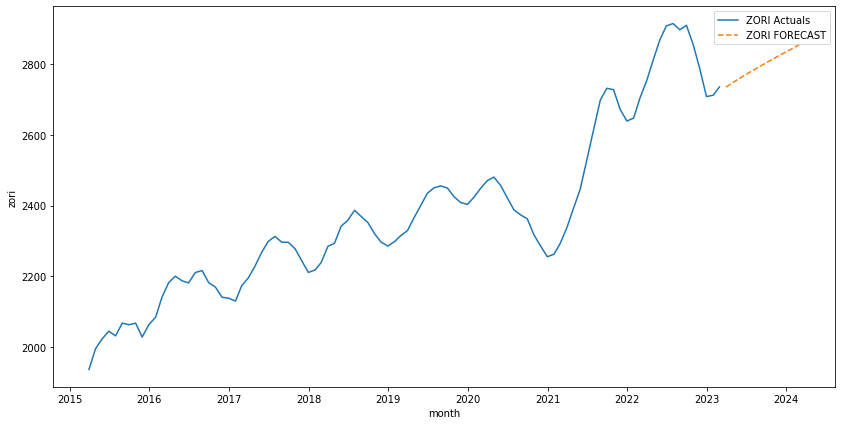

<IPython.core.display.Javascript object>

In [62]:
orig_preds = np.exp(predictions)
anchor = wa_data.zori[wa_data.index == wa_data.index.max()]
pred_df = pd.DataFrame(
    {
        "month": pd.date_range("2023-03-30", "2024-03-01", freq="M"),
        "zori_diff_pred": orig_preds,
    }
)

# Assuming your log returns are stored in a variable called 'log_returns'
# Convert log returns to original values
original_values = [anchor.values[0]]  # assuming X_0 is known
for i in range(1, len(orig_preds)):
    original_values.append(original_values[i - 1] * orig_preds[i])

pred_df["zori_pred"] = original_values
# Print the results
# print(original_values)


g = sns.lineplot(
    data=wa_data.reset_index(),
    x="month",
    y="zori",
    linestyle="solid",
    label="ZORI Actuals",
)
_ = sns.lineplot(
    data=pred_df, x="month", y="zori_pred", linestyle="dashed", label="ZORI FORECAST"
)

-----------------

## 6 Month Horizon

We want to assess how well an ARMA model on log return can predict the zori index 6 months in the future

Let's reserve 2015 through 2018 for model selection (i.e. chosing p and q in the ARMA(p,q))

Then we can evaluate the 6 month predictions with a fixed window TSCV.  Though our ARMA model will forecast on the log return scale, we will assess accuracy on the original ZORI scale.

In [63]:
# Tuning Model
tune_data = wa_data[:"2018"].copy()
tune_data = tune_data[tune_data.zori_lr.notna()]

<IPython.core.display.Javascript object>

In [64]:
tune_model = pm.auto_arima(tune_data.zori_lr, seasonal=False, error_action="ignore")
print("Optimal values of p and q:", tune_model.order)
arma_mod = sm.tsa.arima.ARIMA(tune_data.zori_lr, order=tune_model.order)
res = arma_mod.fit(method="innovations_mle")
print(res.summary())

Optimal values of p and q: (2, 0, 2)
                               SARIMAX Results                                
Dep. Variable:                zori_lr   No. Observations:                   45
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 148.699
Date:                Wed, 22 Mar 2023   AIC                           -285.398
Time:                        07:36:21   BIC                           -274.558
Sample:                    04-30-2015   HQIC                          -281.357
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.003      1.395      0.163      -0.002       0.010
ar.L1         -0.4555      0.173     -2.627      0.009      -0.795      -0.116
ar.L2          

<IPython.core.display.Javascript object>

In [65]:
res.predict(start="2023-01-31", end="2023-07-31")
# res.predict(start=1, end=3)

2023-01-31    0.003973
2023-02-28    0.003973
2023-03-31    0.003973
2023-04-30    0.003973
2023-05-31    0.003973
2023-06-30    0.003973
2023-07-31    0.003973
Freq: M, Name: predicted_mean, dtype: float64

<IPython.core.display.Javascript object>

,lb_stat,lb_pvalue
4,1.001258,0.909605


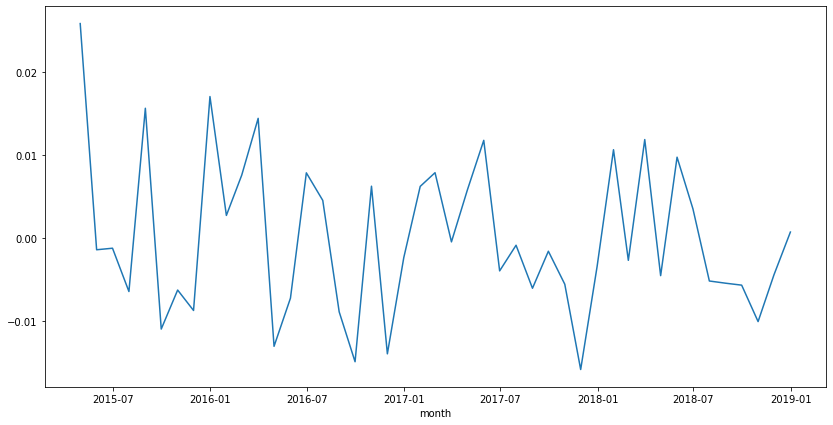

<IPython.core.display.Javascript object>

In [66]:
sns.lineplot(res.resid)
sm.stats.acorr_ljungbox(res.resid, lags=[4], return_df=True)

Since the Ljung Box test is not significant, we can assume there is no autocorrelation in the residuals, 
This suggests the Arima model fits well. 

In [68]:
# On a rolling basis, make predictions 6 months into the future
# Save Results in a dataframe with the log ratio forecast, original scale forecast, horizon
val_df_list = []
for version_month in wa_data["2019":].index:
    train_data = wa_data[:version_month]
    train_data = train_data.iloc[1:]
    # print(f"version_month: {version_month}")
    mod = sm.tsa.arima.ARIMA(train_data.zori_lr, order=tune_model.order)
    fitted_mod = mod.fit(method="innovations_mle")
    fcst_months = pd.date_range(
        start=version_month, periods=7, freq="M", inclusive="right"
    )
    fcst_start = fcst_months.min()
    fcst_end = fcst_months.max()
    fcst = fitted_mod.predict(start=fcst_start, end=fcst_end)
    anchor = wa_data[version_month:version_month].zori.values[0]
    fcst_orig_scale = np.exp(fcst)
    for i in range(len(fcst)):
        fcst_orig_scale[i] = anchor * fcst_orig_scale[i]
        anchor = fcst_orig_scale[i]

    fcst_df = pd.DataFrame(
        {
            "version_month": version_month,
            "target_month": fcst_months,
            "horizon": range(1, 7),
            "zori_lr_pred": fcst.reset_index(drop=True),
            "zori_pred": fcst_orig_scale.reset_index(drop=True),
        }
    )
    val_df_list.append(fcst_df)

val_df = pd.concat(val_df_list)
actuals_data = wa_data.reset_index().copy()
actuals_data = actuals_data.rename(
    columns={"month": "target_month", "zori": "zori_actual"}
)[["target_month", "zori_actual"]]
actuals_data
val_df = val_df.merge(actuals_data, on=["target_month"], how="outer")
val_df.sort_values(["target_month", "version_month"], inplace=True)
val_df

,version_month,target_month,horizon,zori_lr_pred,zori_pred,zori_actual
300,NaT,2015-03-31,NaN,NaN,NaN,1936.065570
301,NaT,2015-04-30,NaN,NaN,NaN,1994.690249
302,NaT,2015-05-31,NaN,NaN,NaN,2023.182831
303,NaT,2015-06-30,NaN,NaN,NaN,2044.498418
304,NaT,2015-07-31,NaN,NaN,NaN,2031.146921
...,...,...,...,...,...,...
295,2023-01-31,2023-06-30,5.0,0.003692,2792.859269,NaN
296,2023-02-28,2023-06-30,4.0,0.004027,2809.243606,NaN
297,2023-01-31,2023-07-31,6.0,0.004154,2804.485500,NaN
298,2023-02-28,2023-07-31,5.0,0.004177,2821.002200,NaN


<IPython.core.display.Javascript object>

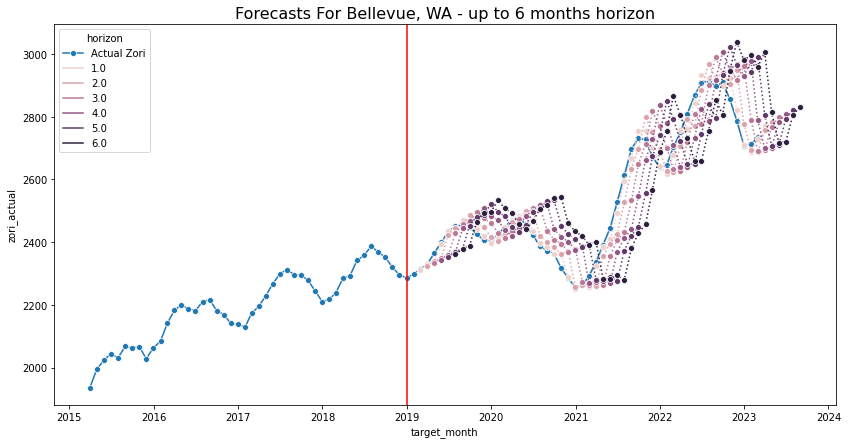

<IPython.core.display.Javascript object>

In [71]:
fig, ax = plt.subplots(1, 1)

g = sns.lineplot(
    data=val_df,
    x="target_month",
    y="zori_actual",
    # hue="horizon",
    linestyle="solid",
    marker="o",
    ax=ax,
    label="Actual Zori",
)
ax.axvline(pd.to_datetime("2019-01-01"), color="red")
_ = sns.lineplot(
    data=val_df,
    x="target_month",
    y="zori_pred",
    hue="horizon",
    linestyle="dotted",
    marker="o",
    ax=ax,
    # label='Forecasted Zori'
)
_ = g.set_title("Forecasts For Bellevue, WA - up to 6 months horizon", fontsize=16)

In [72]:
val_df["perc_error"] = (val_df["zori_actual"] - val_df["zori_pred"]) / val_df[
    "zori_actual"
]
val_df["abs_perc_error"] = abs(val_df["perc_error"])
val_df.groupby(["horizon"]).agg(mape=("abs_perc_error", np.mean))

,mape
horizon,
1.0,0.006750
2.0,0.016401
3.0,0.029290
4.0,0.040055
5.0,0.049013
6.0,0.054880


<IPython.core.display.Javascript object>

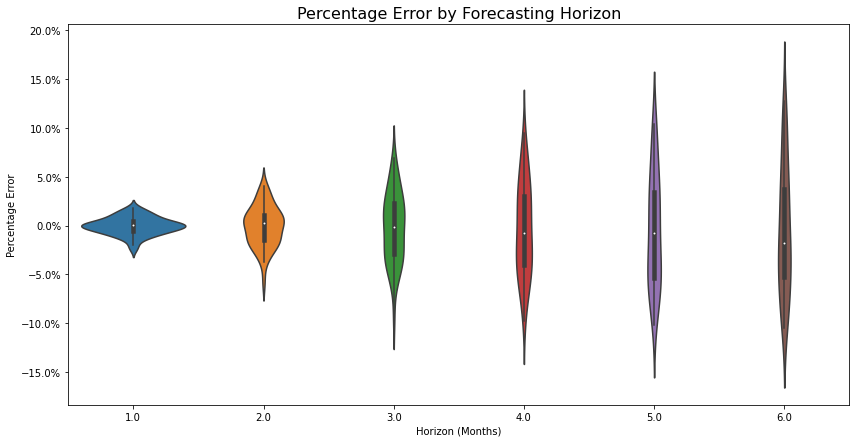

<IPython.core.display.Javascript object>

In [74]:
val_df["horizon_group"] = pd.Categorical(val_df.horizon)
fig, ax = plt.subplots(1, 1)


g = sns.violinplot(data=val_df, y="perc_error", x="horizon_group", ax=ax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
_ = g.set_title("Percentage Error by Forecasting Horizon", fontsize=16)
_ = g.set_ylabel("Percentage Error")
_ = g.set_xlabel("Horizon (Months)")